# 数据读入模块

In [146]:
import pandas as pd


train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [147]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [148]:
train_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in test_data['judicial_reason']]


In [149]:
train_data['nan_num'] = (train_data == 0).astype(int).sum(axis=1)
test_data['nan_num'] = (test_data == 0).astype(int).sum(axis=1)


In [150]:
import pandas as pd
temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")


def chuli_loan(df, colname, ways):
    cust_id = list(set(df['cust_id']))
    res_df = pd.DataFrame({'cust_id': cust_id})
    temp_train = pd.read_csv('./data/df_train.csv')
    temp_test = pd.read_csv('./data/df_test.csv')

    ways_1 = []
    temp = list(temp_test.columns)
    global train_data, test_data

    for i in ways:
        if (colname+'_'+i) not in temp:
            ways_1.append(i)
            res_df[colname+'_'+i] = None
        else:
            print(colname+'_'+i+'已存在')
            train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                  how="left", suffixes=("", "_y"))
            test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                 how="left", suffixes=("", "_y"))
    ways = ways_1
    if len(ways) == 0:
        return res_df
    for i in cust_id:
        cust_df = df[df['cust_id'] == i]
        if 'mean' in ways:
            x = cust_df[colname].mean()
            res_df.loc[i, colname+'_mean'] = x
        if 'sum' in ways:
            x = cust_df[colname].sum()
            res_df.loc[i, colname+'_sum'] = x
        if 'count' in ways:
            x = cust_df[colname].count()
            res_df.loc[i, colname+'_count'] = x
    return res_df


for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
    df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count'))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'date_3', ('count',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_10', ('mean',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_11', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_12', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))


loan1_1_mean已存在
loan1_1_sum已存在
loan1_1_count已存在
loan1_3_mean已存在
loan1_3_sum已存在
loan1_3_count已存在
loan1_7_mean已存在
loan1_7_sum已存在
loan1_7_count已存在
loan1_9_mean已存在
loan1_9_sum已存在
loan1_9_count已存在
date_3_count已存在
loan1_10_mean已存在
loan1_11_sum已存在
loan1_12_sum已存在


## 处理NAN

In [151]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [152]:
df_train = delnan(train_data)
df_test = delnan(test_data)


## 处理-99

In [153]:
df_train.replace(-99, -1, inplace=True)
df_test.replace(-99, -1, inplace=True)


In [154]:
df_train.to_csv('./data/df_train.csv')
df_test.to_csv('./data/df_test.csv')


## 主成分分析（效果不好）

In [155]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]


## 处理分类变量

In [156]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25", ]


## 转化为one-hot编码（不宜采用）

In [157]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """


' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [158]:
import pandas as pd
import numpy as np


def cal_woe(df, df_no_label, x_cols, y_col):
    for i in x_cols:
        x_set = pd.unique(df[i])
        for j in x_set:
            woe = np.mean(df[df[i] == j][y_col])
            df[i].replace(j, woe, inplace=True)
            df_no_label[i].replace(j, woe, inplace=True)
    return df, df_no_label


In [159]:
df_train, df_test = cal_woe(df_train, df_test, type_col, "label")


In [160]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col = [i for i in full_col_name if "judicial" in i]
loan_pca_col = [i for i in full_col_name if "loan_pca" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """


' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## rank化

In [161]:
def rank(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# rank(c)


## 归一化

In [162]:
def norm(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
norm(c)


## 标准化

In [163]:
def stand(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.mean(df[i], axis=0))/np.std(df[i], axis=0)
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# stand(c)


## 设置哪些x作为模型自变量输入

In [164]:
x_col = basic_col+['is_judicial']+loan_col+['date_3_count']


In [165]:
# df_train.drop(columns=drop_col)


# 训练模型

## 超参数

In [166]:
N = 1000
num_round = 100
local_test_size = 300

max_depth = [3, 4, 5, 6, 7, 8]
eta = [0.1, 0.06]
colsample_bytree = [0.8, 0.7, 0.6]
scale_pos_weight = [1, 3, 6, 10, 20, 30]
test_size = [0.3, 0.2, 0.4, 0.5, 0.6, 0.7]
subsample = [0.8, 0.7, 0.6, 0.5, 0.4]
par_lambda = [1, 1.5, 2, 3]
alpha = [0, 0.2, 0.4, 0.6, 0.8]
min_child_weight = [1, 2, 3, 4, 5]
gamma = [0, 0.05, 0.1, 0.15, 0.2]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [167]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag = 0
important_x_seq = []

num_seq = list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test = df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test = df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest = xgb.DMatrix(X_local_test, label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round = random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample': random.choice(subsample),
        'alpha': random.choice(alpha),
        'lambda': random.choice(par_lambda),
        'min_child_weight': random.choice(min_child_weight),
        'gamma': random.choice(gamma),
        # 'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        # "enable_enable_categorical":True,
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=5, verbose_eval=False)

    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc': local_test_loss, 'test_size': test_size_this_round}
    temp_dict.update(param)

    # info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag == 0:
        info_df = pd.DataFrame(temp_dict, index=[i])
        flag = 1
    else:
        info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss

    if False:
        pic = xgb.plot_importance(bst, max_num_features=50)
        temp = pic.get_ymajorticklabels()
        important_x = [str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq += important_x

    print(i+1, ":", loss, sep="")
    # print(param)
    # print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")


1:0.674868127083378
2:0.6438928670778616
3:0.6540170947656038
4:0.6158730200962699
5:0.6377200558660547
6:0.6285658569199911
7:0.7028375714469682
8:0.6094999702881885
9:0.6407096877486921
10:0.6974905174642363
11:0.6700872789981701
12:0.7002919295237455
13:0.6342443419738658
14:0.7017219670921535
15:0.6566748393250726
16:0.6893635112639727
17:0.6750372759451632
18:0.6569393843224374
19:0.6887675419262392
20:0.6683464551941393
21:0.6678881594942864
22:0.6270286855216881
23:0.6835192183611393
24:0.702532962188828
25:0.6890353864305653
26:0.665486629592077
27:0.6302862267511795
28:0.6350534497069699
29:0.6398914319248826
30:0.659396887159533
31:0.651879346961071
32:0.5
33:0.6655382294856889
34:0.667173357840805
35:0.5
36:0.6556922957282926
37:0.6333276340197493
38:0.6482799341215801
39:0.6370236632161024
40:0.6892522380739421
41:0.6338869878620593
42:0.6542653323322227
43:0.6360895893171373
44:0.6174578720341821
45:0.6486840409956076
46:0.6586904787024432
47:0.6597167639486106
48:0.660727

In [168]:
info_df


,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,gamma,tree_method,gpu_id
0,0.674868,0.915702,0.758562,0.2,8,0.06,0.7,binary:logistic,3,auc,0.7,0.4,3.0,2,0.00,gpu_hist,0
1,0.643893,0.926876,0.552226,0.4,6,0.06,0.6,binary:logistic,6,auc,0.7,0.4,2.0,4,0.20,gpu_hist,0
2,0.654017,0.756684,0.677012,0.3,4,0.06,0.7,binary:logistic,1,auc,0.6,0.8,2.0,3,0.20,gpu_hist,0
3,0.615873,0.787404,0.550300,0.5,8,0.06,0.8,binary:logistic,1,auc,0.7,0.2,1.0,3,0.00,gpu_hist,0
4,0.637720,0.765888,0.621789,0.2,3,0.06,0.8,binary:logistic,20,auc,0.7,0.0,1.0,1,0.20,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.661141,0.776769,0.593964,0.5,3,0.10,0.6,binary:logistic,3,auc,0.6,0.4,3.0,5,0.05,gpu_hist,0
996,0.691657,0.942370,0.774829,0.4,5,0.10,0.7,binary:logistic,10,auc,0.7,0.0,3.0,2,0.00,gpu_hist,0
997,0.644188,0.903841,0.630993,0.2,5,0.10,0.8,binary:logistic,30,auc,0.8,0.8,1.5,2,0.20,gpu_hist,0
998,0.546882,0.623566,0.550514,0.7,6,0.10,0.8,binary:logistic,1,auc,0.5,0.8,1.5,1,0.05,gpu_hist,0


In [169]:
info_df.to_csv("info.csv", encoding="utf-8", index=False)


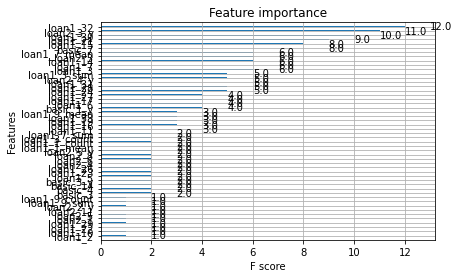

In [170]:
pic = xgb.plot_importance(best_bst, max_num_features=50)
temp = pic.get_ymajorticklabels()
important_x = [str(i).split("\'")[1] for i in temp]
important_x.reverse()


In [171]:
important_x


['loan1_32',
 'loan2_3_y',
 'loan1_30',
 'loan1_21',
 'loan1_15',
 'basic_7',
 'loan1_7_mean',
 'loan2_3',
 'loan1_14',
 'loan1_7',
 'loan1_3',
 'loan1_3_sum',
 'loan2_4_y',
 'loan1_31',
 'loan1_28',
 'loan1_24',
 'loan1_27',
 'loan1_17',
 'loan1_6',
 'basic_1_y',
 'loan1_9_mean',
 'loan1_33',
 'loan1_19',
 'loan1_16',
 'loan1_11',
 'loan1_7_sum',
 'loan1_3_count',
 'loan1_1_count',
 'loan1_1_mean',
 'loan2_5_y',
 'loan2_8',
 'loan2_6',
 'loan2_4',
 'loan1_26',
 'loan1_23',
 'loan1_5',
 'basic_3_y',
 'basic_14',
 'basic_4',
 'basic_3',
 'loan1_9_count',
 'loan1_9_sum',
 'loan2_2_y',
 'loan2_11',
 'loan2_5',
 'loan2_1',
 'loan1_29',
 'loan1_22',
 'loan1_10',
 'loan1_2']

In [172]:
# pd.value_counts(important_x_seq)


* basic_7:年龄
* 

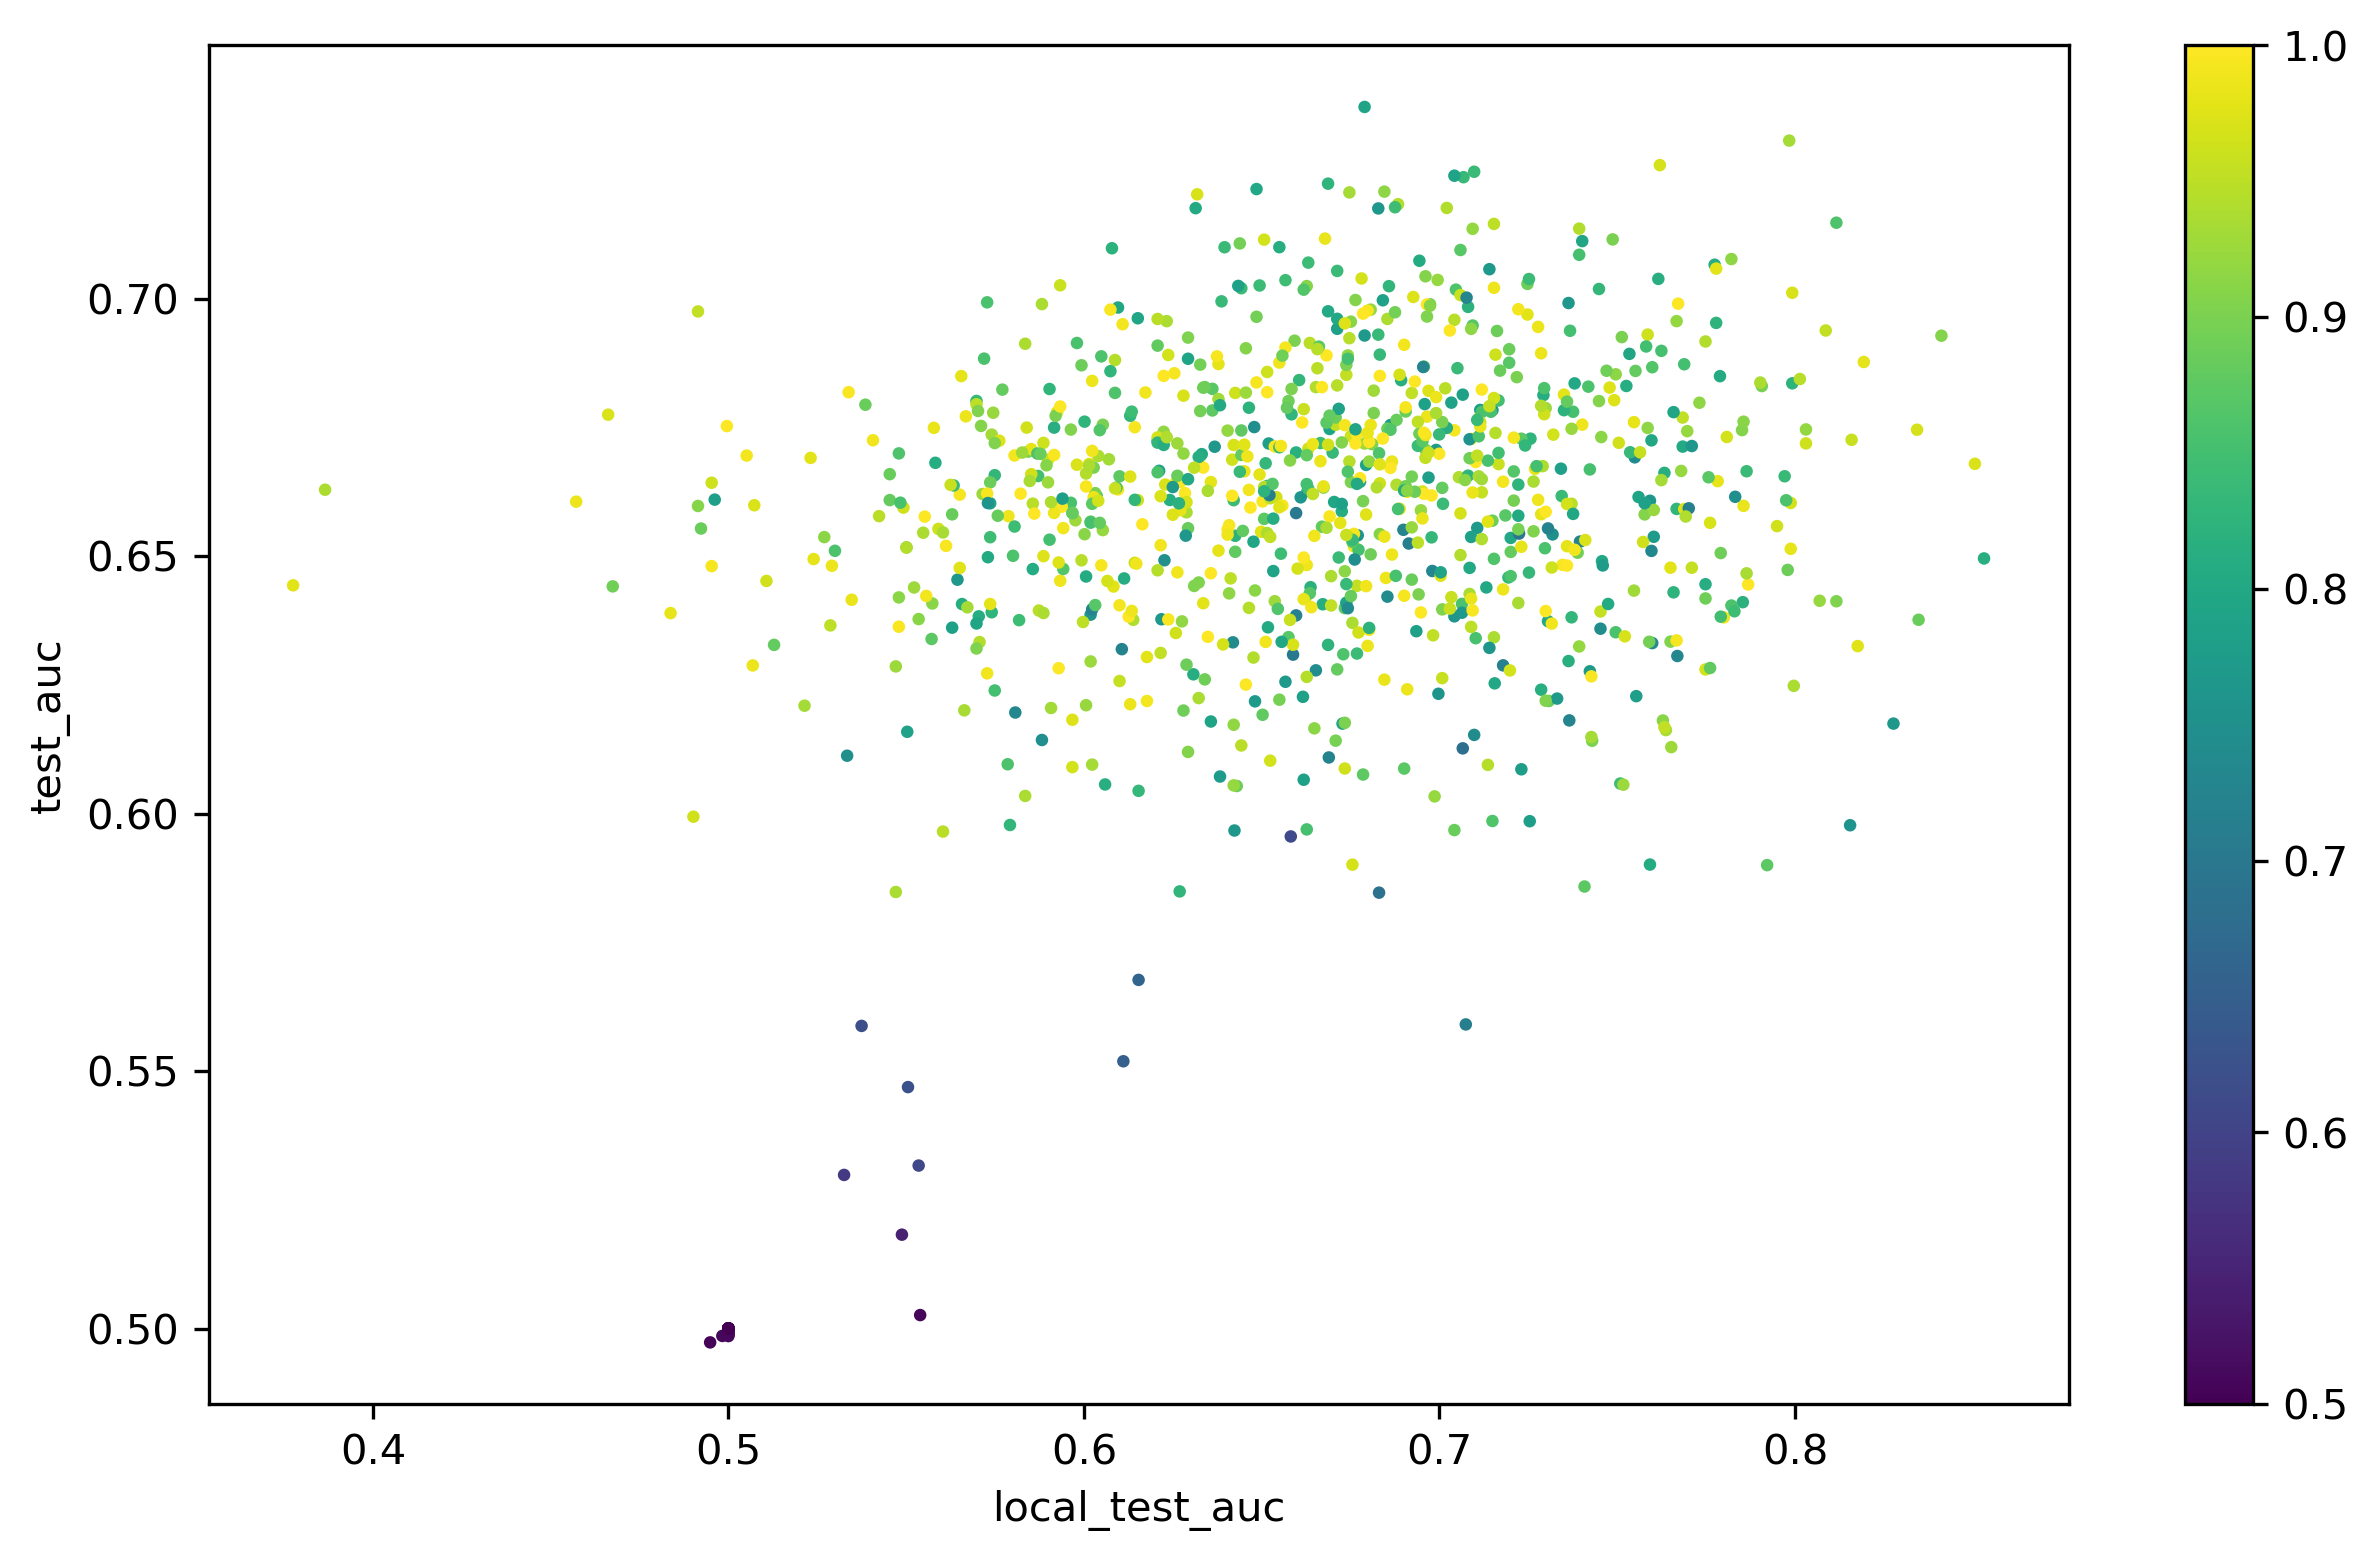

In [185]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(info_df['local_test_auc'], info_df['test_auc'],c=info_df['train_auc'],s=4)
plt.xlabel('local_test_auc')
plt.ylabel('test_auc')
plt.colorbar()

# 输出模块

In [186]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        # 算数平均
        # temp = np.mean(list_temp, axis=0)
        # 几何平均(better)
        temp = np.exp(np.mean(np.log(list_temp), axis=0))
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 100
    n = min(N, n)

res_num = res_num[0:n]

#final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
final_pred_label = np.exp(
    np.mean(np.log([pred_labels[i] for i in res_num]), axis=0))
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [
      list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后AUC为", max_auc, sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


0 0.8531678082191781
1 0.8762842465753425
2 0.8848458904109588
3 0.8839897260273973
4 0.891695205479452
5 0.894263698630137
6 0.8998287671232876
7 0.8972602739726027
8 0.8955479452054795
9 0.8951198630136986
10 0.8946917808219178
11 0.8874143835616439
12 0.8891267123287673
13 0.8951198630136987
14 0.8938356164383562
15 0.8912671232876713
16 0.8874143835616438
17 0.8852739726027397
18 0.8801369863013698
19 0.8784246575342466
20 0.8779965753424658
21 0.8822773972602739
22 0.879708904109589
23 0.8784246575342466
24 0.8745719178082192
25 0.875
26 0.8737157534246575
27 0.8732876712328768
28 0.8724315068493151
29 0.872431506849315
30 0.8732876712328766
31 0.872431506849315
32 0.8724315068493151
33 0.8741438356164384
34 0.8732876712328768
35 0.8720034246575342
36 0.8732876712328766
37 0.8732876712328768
38 0.8741438356164384
39 0.8741438356164384
40 0.8745719178082192
41 0.8758561643835616
42 0.875
43 0.8745719178082192
44 0.8741438356164383
45 0.872859589041096
46 0.8745719178082192
47 0.873

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用